# Predictive Model for Stock Management

## 0. Scope the Project

Our plan is to use a predictive modeling technique to estimate the ideal weekly order quantity for each product **using historical sales data that reflects past demand patterns and trends.** The model will account for the average supplier lead time of 5 business days to ensure timely restocking.

By anticipating demand more accurately, this initiative aims to **optimize stock levels, reduce excess inventory, and prevent stockouts—ultimately improving operational efficiency and financial performance.**

In [210]:
!pip install pmdarima

## 1. Libraries

In [212]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.model_selection import TimeSeriesSplit

import warnings # filters warning during the script
warnings.filterwarnings("ignore")

## 2. Gather Data

In [214]:
cities = pd.read_csv("../datasets/cities.csv")
cities.head()

,store_id,storetype_id,store_size,city_id_old,country_id,city_code
0,S0036,ST04,21,C001,TURKEY,Denizli
1,S0005,ST04,19,C001,TURKEY,Denizli
2,S0104,ST04,47,C002,TURKEY,Ankara
3,S0068,ST03,14,C003,TURKEY,?zmir
4,S0086,ST03,12,C003,TURKEY,?zmir


In [215]:
product = pd.read_csv("../datasets/product.csv")
product.head()

,product_id,product_length,product_depth,product_width,cluster_id,hierarchy1_id,hierarchy2_id,hierarchy3_id,hierarchy4_id,hierarchy5_id
0,P0000,5.0,20.0,12.0,NaN,H00,H0004,H000401,H00040105,H0004010534
1,P0001,13.5,22.0,20.0,cluster_5,H01,H0105,H010501,H01050100,H0105010006
2,P0002,22.0,40.0,22.0,cluster_0,H03,H0315,H031508,H03150800,H0315080028
3,P0004,2.0,13.0,4.0,cluster_3,H03,H0314,H031405,H03140500,H0314050003
4,P0005,16.0,30.0,16.0,cluster_9,H03,H0312,H031211,H03121109,H0312110917


In [216]:
product["hierarchy2_id"].nunique()

18

In [217]:
sales = pd.read_csv("../datasets/sales.csv")
sales.head()

,Unnamed: 0,store_id,product_id,date,sales,revenue,stock,price,promo_type_1,promo_bin_1,promo_type_2,promo_bin_2,promo_discount_2,promo_discount_type_2
0,1,S0002,P0001,2017-01-02,0.0,0.00,8.0,6.25,PR14,NaN,PR03,NaN,NaN,NaN
1,2,S0002,P0005,2017-01-02,0.0,0.00,11.0,33.90,PR14,NaN,PR03,NaN,NaN,NaN
2,3,S0002,P0011,2017-01-02,0.0,0.00,9.0,49.90,PR14,NaN,PR03,NaN,NaN,NaN
3,4,S0002,P0015,2017-01-02,1.0,2.41,19.0,2.60,PR14,NaN,PR03,NaN,NaN,NaN
4,5,S0002,P0017,2017-01-02,0.0,0.00,12.0,1.49,PR14,NaN,PR03,NaN,NaN,NaN


In [218]:
#sales.shape

In [219]:
#sales.info()

## 3. Clean Data

### a.Convert Data Types

In [222]:
#Changing datetypes
sales.date = pd.to_datetime(sales.date)

### b. Removing Columns

In [224]:
#Remove "Unnamed: 0 column"
sales = sales.drop("Unnamed: 0", axis=1)

### c. Resolve Data Issues

#### i. Missing Data

In [227]:
#Find NaN values in the data - sales, revenue, stock, price, promo_bin_1, promo_bin_2, promo_discont_2
sales.isna().sum()

store_id                       0
product_id                     0
date                           0
sales                     302296
revenue                   302296
stock                     302296
price                      91381
promo_type_1                   0
promo_bin_1              7653515
promo_type_2                   0
promo_bin_2              8873337
promo_discount_2         8873337
promo_discount_type_2    8873337
dtype: int64

In [228]:
#Find NaN values in the data - product length, product_depth, product_width, cluster_id
product.isna().sum()

product_id         0
product_length    18
product_depth     16
product_width     16
cluster_id        50
hierarchy1_id      0
hierarchy2_id      0
hierarchy3_id      0
hierarchy4_id      0
hierarchy5_id      0
dtype: int64

In [229]:
#No missing values
cities.isna().sum()

store_id        0
storetype_id    0
store_size      0
city_id_old     0
country_id      0
city_code       0
dtype: int64

In [230]:
# Fill sales, revenue, stock NaN values = 0
# Fill promo tables NaN's values with 0

#sales[["sales", "revenue", "stock"]] = sales[["sales", "revenue", "stock"]].fillna(0)
#sales[["promo_bin_1", "promo_bin_2", "promo_discount_2", "promo_discount_type_2"]] = sales[["promo_bin_1", "promo_bin_2", "promo_discount_2", "promo_discount_type_2"]].fillna(0)

In [231]:
# Product Table
## Fill cluster_id NaN with cluster_0
#product["cluster_id"] = np.where(product.cluster_id.isna(), "cluster_0", product.cluster_id)
#product.cluster_id.value_counts(dropna=False)

In [232]:
## This will fill the missing values in the product_length, product_depth, and product_width columns 
## based on the mean for each specific cluster_id
#for col in ["product_length", "product_depth", "product_width"]:
    
#    for cluster in product['cluster_id'].unique():
#        mean_value = product[product['cluster_id'] == cluster][col].mean()
        
#        product.loc[product['cluster_id'] == cluster, col] = product.loc[product['cluster_id'] == cluster, col].fillna(mean_value)


#### ii. Inconsistent Text & Typos

In [234]:
#Correct city_code typos
replacements = {
    "?zmir": "Izmir",
    "Sanl?urfa": "Sanliurfa",
    "Diyarbak?r": "Diyarbakir",
    "Eski?ehir": "Eskisehir",
    "Adapazar?": "Adapazari"
}

cities["city_code"] = cities.city_code.replace(replacements)
cities.city_code.value_counts()

city_code
Istanbul         32
Antalya           5
Sanliurfa         3
Konya             3
Denizli           2
Kahramanmaras     2
Samsun            2
Van               2
Izmir             2
Gaziantep         1
Ankara            1
Diyarbakir        1
Kayseri           1
Adana             1
Bursa             1
Eskisehir         1
Adapazari         1
Erzurum           1
Mersin            1
Name: count, dtype: int64

#### iii. Duplicate Rows

In [236]:
# There seem to be no duplicated rows

In [237]:
sales[sales.duplicated()]

,store_id,product_id,date,sales,revenue,stock,price,promo_type_1,promo_bin_1,promo_type_2,promo_bin_2,promo_discount_2,promo_discount_type_2


In [238]:
product[product.duplicated()]

,product_id,product_length,product_depth,product_width,cluster_id,hierarchy1_id,hierarchy2_id,hierarchy3_id,hierarchy4_id,hierarchy5_id


In [239]:
cities[cities.duplicated()]

,store_id,storetype_id,store_size,city_id_old,country_id,city_code


#### iv. Outliers

### c. Create New Columns

In [242]:
# Week column
sales["week"] = sales.date.dt.to_period("W").apply(lambda r: r.start_time)
sales.head()

,store_id,product_id,date,sales,revenue,stock,price,promo_type_1,promo_bin_1,promo_type_2,promo_bin_2,promo_discount_2,promo_discount_type_2,week
0,S0002,P0001,2017-01-02,0.0,0.00,8.0,6.25,PR14,NaN,PR03,NaN,NaN,NaN,2017-01-02
1,S0002,P0005,2017-01-02,0.0,0.00,11.0,33.90,PR14,NaN,PR03,NaN,NaN,NaN,2017-01-02
2,S0002,P0011,2017-01-02,0.0,0.00,9.0,49.90,PR14,NaN,PR03,NaN,NaN,NaN,2017-01-02
3,S0002,P0015,2017-01-02,1.0,2.41,19.0,2.60,PR14,NaN,PR03,NaN,NaN,NaN,2017-01-02
4,S0002,P0017,2017-01-02,0.0,0.00,12.0,1.49,PR14,NaN,PR03,NaN,NaN,NaN,2017-01-02


## 4. EDA

In [244]:
# Weekly_sales Df creation
weekly_sales = (sales.groupby(["store_id", "product_id", "week"])
    .agg({
        "sales": "sum",
        "revenue": "sum",
        "stock": "mean",
        "price": "mean",
#        "promo_bin_1": lambda x: 0 if (x == 0).all() else 1, # use if there's no NaN's
#        "promo_bin_2": lambda x: 0 if (x == 0).all() else 1  # use if there's no NaN's
        'promo_bin_1': lambda x: 1 if x.notna().any() else 0,
        'promo_bin_2': lambda x: 1 if x.notna().any() else 0
    })
 .reset_index())

In [245]:
# Merged weekly_sales, product and cities - full_df 
full_df = (weekly_sales
           .merge(product, how="left", on="product_id")
           .merge(cities, how="left", on="store_id")
          )

## 5. Prep for Modeling

## 6. Model - ARIMA

### Generating Tables

In [249]:
df_isna = (weekly_sales
 .merge(product, how="left", on="product_id")
 .merge(cities, how="left", on="store_id")
)

df_isna.info() # Dataset merged with NaN's

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308210 entries, 0 to 1308209
Data columns (total 23 columns):
 #   Column          Non-Null Count    Dtype         
---  ------          --------------    -----         
 0   store_id        1308210 non-null  object        
 1   product_id      1308210 non-null  object        
 2   week            1308210 non-null  datetime64[ns]
 3   sales           1308210 non-null  float64       
 4   revenue         1308210 non-null  float64       
 5   stock           1267789 non-null  float64       
 6   price           1293928 non-null  float64       
 7   promo_bin_1     1308210 non-null  int64         
 8   promo_bin_2     1308210 non-null  int64         
 9   product_length  1302350 non-null  float64       
 10  product_depth   1302675 non-null  float64       
 11  product_width   1302675 non-null  float64       
 12  cluster_id      1308210 non-null  object        
 13  hierarchy1_id   1308210 non-null  object        
 14  hierarchy2_id   13

In [250]:
df_isna.isna().sum()

store_id              0
product_id            0
week                  0
sales                 0
revenue               0
stock             40421
price             14282
promo_bin_1           0
promo_bin_2           0
product_length     5860
product_depth      5535
product_width      5535
cluster_id            0
hierarchy1_id         0
hierarchy2_id         0
hierarchy3_id         0
hierarchy4_id         0
hierarchy5_id         0
storetype_id          0
store_size            0
city_id_old           0
country_id            0
city_code             0
dtype: int64

In [251]:
# Preparation of data
df_isna_filtered = df_isna[(df_isna["store_id"] == "S0085") & (df_isna["product_id"] == "P0015")] #Dataset Filtered by Store S0085
# Product P0015
df_isna_filtered_week = df_isna_filtered.groupby("week")["sales"].sum().sort_index() # sorts the df by its index (row or column)
df_isna_filtered_week.values # Assuring that the dataset is an array -  grouped by week and the total sales

array([18., 40., 10.,  4.,  7.,  4.,  6.,  7., 10.,  4.,  2.,  3.,  3.,
        2.,  2.,  2., 11.,  7.,  7.,  8.,  5., 12.,  9.,  0.,  9.,  5.,
        7., 12., 14., 16., 11., 20., 46., 13., 14.,  6., 13., 15., 11.,
        8., 12., 11.,  8.,  6.,  7., 19., 32.,  6., 10., 10.,  8., 15.,
       14., 10.,  4.,  4.,  6.,  9.,  8.,  7.,  4., 12.,  9., 12.,  6.,
       18., 19.,  6., 31., 29.,  9., 16.,  7., 17., 26., 18.,  6.,  7.,
       14., 15., 19., 15., 18., 15., 16., 19., 25., 15., 17., 10., 13.,
       11.,  9.,  5.,  6.,  7.,  6.,  4., 11.,  9.,  2.,  2.,  3., 10.,
        9.,  1.,  1.,  3.,  8.,  1.,  4.,  2.,  5.,  3.,  3.,  3.,  1.,
        1.,  0.,  1.,  2.,  4.,  3.,  3.,  1.,  4., 12., 10.,  2.,  2.,
       10.,  4.,  4.,  0.,  4.,  6.,  5., 12.,  9.,  7.,  6.,  7.,  7.,
        1.,  0.,  0.,  0.,  0.])

Important steps:

- Preparation table per weekly w/x(features: stock), y(target: sales):

- missing values 0 stock & price

- Filter by select stores and then select hierarchies

- x(features: stock), y(target: sales)

- Think if using mean on aggregated categoric products or sum (Search information about it to justify)

In [253]:
### Fill na values
df_fillna = df_isna.fillna(value={"stock": 0, "price": 0}) # set only stock and price to 0 

#df_fillna.isna().sum()
print(df_fillna.head())

  store_id product_id       week  sales  revenue     stock     price  \
0    S0002      P0001 2017-01-02    2.0    10.59  7.428571  6.250000   
1    S0002      P0001 2017-01-09    3.0    16.32  4.571429  6.321429   
2    S0002      P0001 2017-01-16    2.0    11.02  1.714286  6.500000   
3    S0002      P0001 2017-01-23    0.0     0.00  1.000000  6.500000   
4    S0002      P0001 2017-01-30    0.0     0.00  1.000000  6.500000   

   promo_bin_1  promo_bin_2  product_length  ...  hierarchy1_id  \
0            0            0            13.5  ...            H01   
1            0            0            13.5  ...            H01   
2            0            0            13.5  ...            H01   
3            0            0            13.5  ...            H01   
4            0            0            13.5  ...            H01   

   hierarchy2_id hierarchy3_id hierarchy4_id hierarchy5_id storetype_id  \
0          H0105       H010501     H01050100   H0105010006         ST04   
1          H01

In [254]:
# Creation of Hierarchy df's
df_h00 = df_fillna[(df_fillna["store_id"].isin(["S0085", "S0095", "S0026", "S0080"])) & (df_fillna["hierarchy1_id"] == "H00")]
df_h01 = df_fillna[(df_fillna["store_id"].isin(["S0085", "S0095", "S0026", "S0080"])) & (df_fillna["hierarchy1_id"] == "H01")]
df_h02 = df_fillna[(df_fillna["store_id"].isin(["S0085", "S0095", "S0026", "S0080"])) & (df_fillna["hierarchy1_id"] == "H02")]
df_h03 = df_fillna[(df_fillna["store_id"].isin(["S0085", "S0095", "S0026", "S0080"])) & (df_fillna["hierarchy1_id"] == "H03")]

In [255]:
df_h00.head()

,store_id,product_id,week,sales,revenue,stock,price,promo_bin_1,promo_bin_2,product_length,...,hierarchy1_id,hierarchy2_id,hierarchy3_id,hierarchy4_id,hierarchy5_id,storetype_id,store_size,city_id_old,country_id,city_code
234210,S0026,P0008,2018-04-02,0.0,0.00,12.000000,6.0,0,0,5.0,...,H00,H0000,H000004,H00000400,H0000040017,ST04,41,C014,TURKEY,Istanbul
234211,S0026,P0008,2018-04-09,0.0,0.00,12.000000,6.0,0,0,5.0,...,H00,H0000,H000004,H00000400,H0000040017,ST04,41,C014,TURKEY,Istanbul
234212,S0026,P0008,2018-04-16,0.0,0.00,12.000000,6.0,0,0,5.0,...,H00,H0000,H000004,H00000400,H0000040017,ST04,41,C014,TURKEY,Istanbul
234213,S0026,P0008,2018-04-23,3.0,16.68,9.428571,6.0,0,0,5.0,...,H00,H0000,H000004,H00000400,H0000040017,ST04,41,C014,TURKEY,Istanbul
234214,S0026,P0008,2018-04-30,2.0,11.12,8.428571,6.0,0,0,5.0,...,H00,H0000,H000004,H00000400,H0000040017,ST04,41,C014,TURKEY,Istanbul


In [256]:
df_h00_model = (round(df_h00
       .groupby("week")[["sales", "stock", "promo_bin_1", "promo_bin_2", "price", "store_id", "product_id", "store_size"]]
       .agg({
           "sales": "sum", # total weekly sales 
           "stock": "mean", #avg stock for the week #maybe test median
          "promo_bin_1": "mean", # % of products with promo
           "promo_bin_2": "mean", # % of products with promo
           "price": "mean", # average price in the week
           "product_id": pd.Series.nunique, # how many unique products were sold this week (breadth)
           "store_size": "mean" # average store size
       })
       .rename(columns={"product_id": "n_unique_products"})
       ,2))

df_h00_model["week_number"] = df_h00_model.index.isocalendar().week #adding week to dataframe
df_h00_model["month"] = df_h00_model.index.month #adding month to dataframe
df_h00_model["year"] = df_h00_model.index.year #adding year to dataframe

df_h00_model.head()

,sales,stock,promo_bin_1,promo_bin_2,price,n_unique_products,store_size,week_number,month,year
week,,,,,,,,,,
2017-01-02,4832.57,39.32,0.18,0.0,6.31,114,44.22,1,1,2017
2017-01-09,5446.46,37.35,0.04,0.0,6.34,114,44.19,2,1,2017
2017-01-16,5764.71,44.81,0.11,0.0,6.27,114,44.23,3,1,2017
2017-01-23,6355.06,41.10,0.07,0.0,6.37,115,44.21,4,1,2017
2017-01-30,6282.21,41.46,0.13,0.0,6.35,115,44.18,5,1,2017


### Stationarity

In [258]:
# Check for stationarity - df_isna_filtered_week
#results = adfuller(df_isna_filtered_week)
#print(f"ADF Statistics: {results[0]:.4f}")
#print(f"p-value: {results[1]:.4f}")

In [259]:
# Check for stationarity - df_h00_model
statio_df_h00_model = adfuller(df_h00_model["sales"])
print(f"ADF Statistics: {statio_df_h00_model[0]:.4f}")
print(f"p-value: {statio_df_h00_model[1]:.4f}")

# We can assume stationary but its worth it to try d = 1 in the arima models

ADF Statistics: -2.8669
p-value: 0.0493


### Differencing

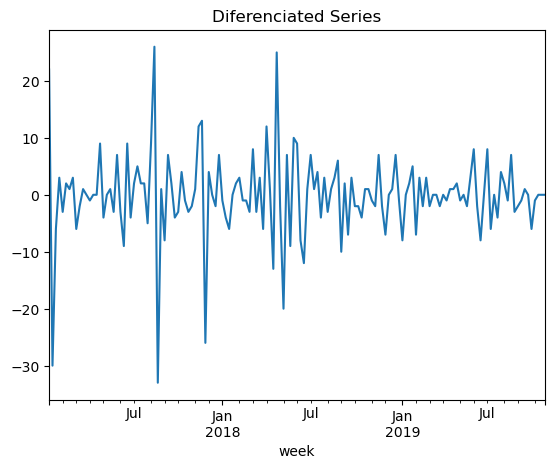

In [261]:
diff_data = df_isna_filtered_week.diff().dropna() # dropna to eliminate first row of nan
diff_data.plot(title="Diferenciated Series")
plt.show()

In [262]:
# Check again stationary
results_diff = adfuller(diff_data)
print(f"ADF statistics: {results_diff[0]:.4f}")
print(f"p-value: {results_diff[1]:.4f}")
## p-value: 0.00 < 0.05 = Reject Null Hypothesis (Series is stationary)

ADF statistics: -10.6827
p-value: 0.0000


<Axes: xlabel='week'>

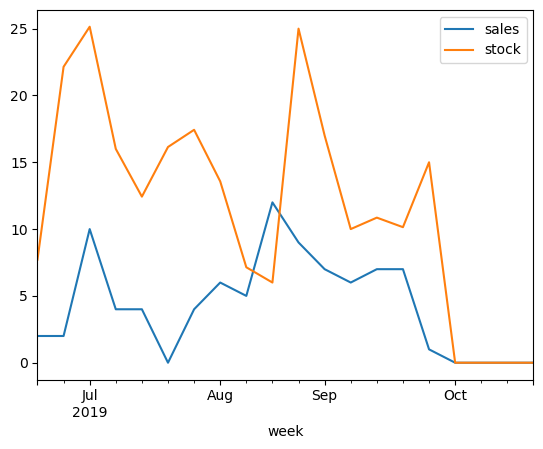

In [263]:
df_isna_filtered.groupby("week")[["sales", "stock"]].sum().sort_index().tail(20).plot()

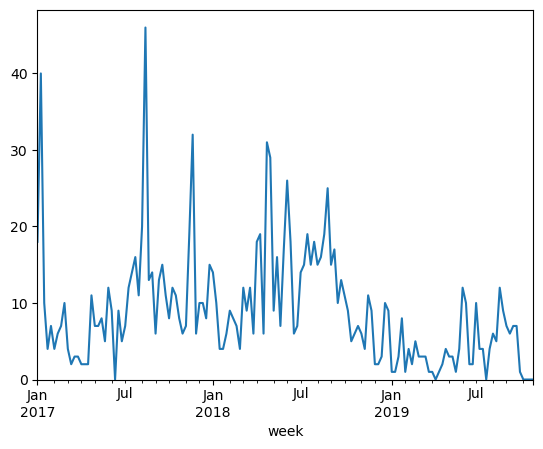

In [264]:
df_isna_filtered_week.plot(ylim=0);

### Seasonality & trends

#### Smoothing - Rolling AVG.

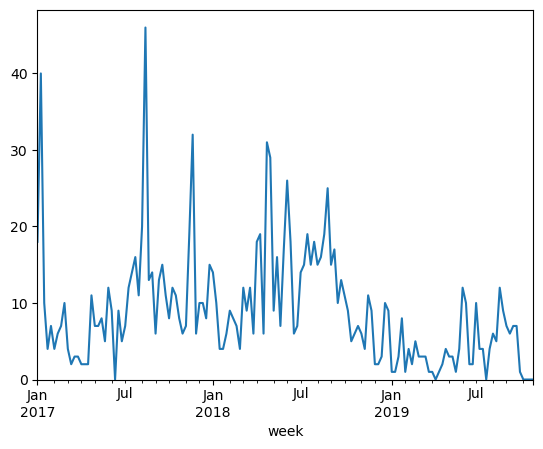

In [267]:
# Identify components of the time series:
## Trend
## Seasonality
## Noise
df_isna_filtered_week.plot(ylim=0);

In [268]:
# Smooth Time Series (4 weeks - 3 Months)

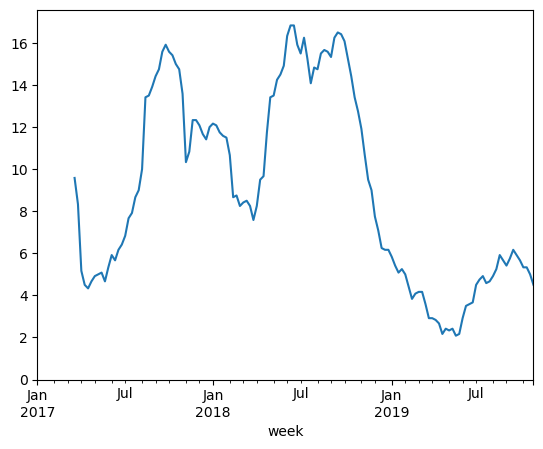

In [269]:
df_isna_filtered_week.rolling(4*3).mean().plot(ylim=0);

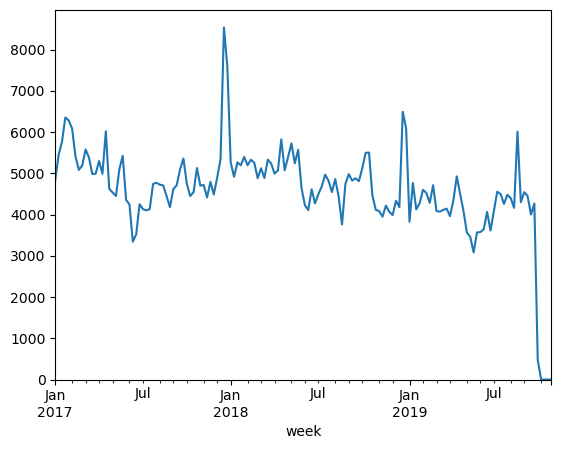

In [270]:
df_h00_model["sales"].plot(ylim=0);

#### Decomposition

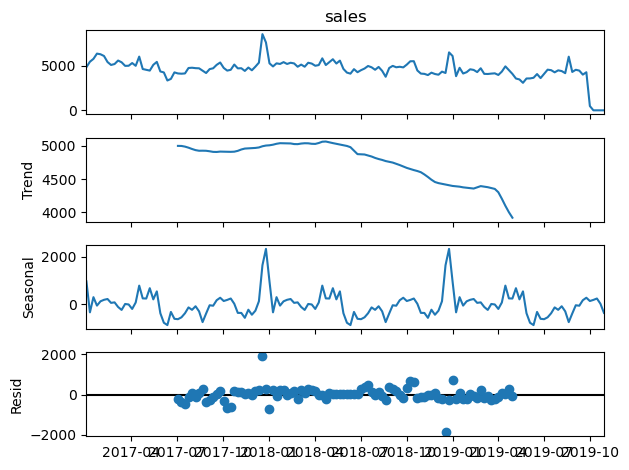

In [272]:
decompose = seasonal_decompose(df_h00_model["sales"], model="additive", period=52)
decompose.plot();

#### AutoCorrelation & Partial AutoCorrelation

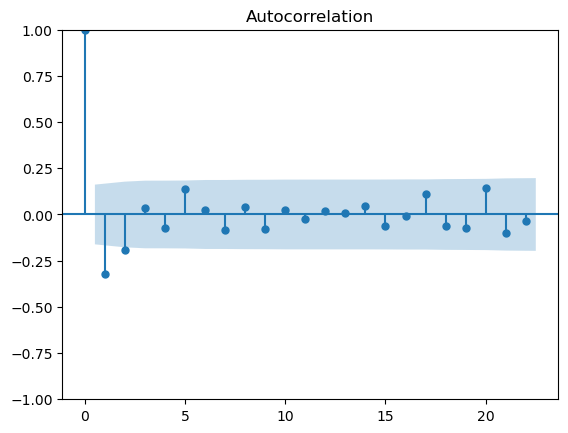

In [274]:
plot_acf(diff_data); # diff_data is the differenciated data - when doing ACF is mandatory to remove any trend

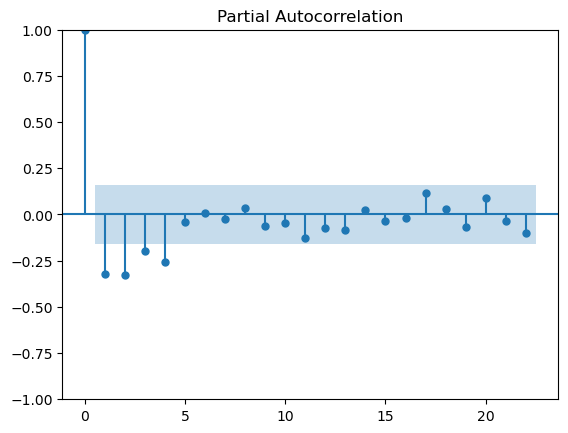

In [275]:
plot_pacf(diff_data);

### Train-Test Split 

In [277]:
train_data = df_h00_model.iloc[:-4]
test_data = df_h00_model.iloc[-4:]

print(len(train_data))
print(len(test_data))
print(train_data.index.max()) # last week of training data
print(test_data.index.min()) # first week of test data

144
4
2019-09-30 00:00:00
2019-10-07 00:00:00


### AutoARIMA - XREG / ARIMAX

### Auto-ARIMA

| Strength                                      | Why it matters for inventory                                                                                   |
| --------------------------------------------- | -------------------------------------------------------------------------------------------------------------- |
| 📉 **Short-term accuracy**                    | ARIMA excels at capturing local patterns like last few weeks’ sales — critical for weekly inventory decisions. |
| 🧮 **Interpretable**                          | Easy to understand and control: “Use last 2 weeks, difference once, correct with recent error.”                |
| 🔁 **Well-tested for univariate time series** | Forecasting **one variable** (sales per product/store) is ARIMA’s wheelhouse.                                  |


#### Fit Auto-Arima Model

In [282]:
# Define target and exogenous variables
y_train = train_data["sales"]
y_test = test_data["sales"]

model_arima = auto_arima(
    y_train, # Train target variable
    seasonal=True, # Seasonal Set true because data shows weekly seasonality
    m=52, # The period for seasonal differencing "52 weeks"
    stepwise=True, # Auto-Arima model selection to find the best ARIMA parameters
    trace=True, #print status on the fits
    error_action="ignore" # Ignores errors
)

# Summary
## There's no need to use fit() because Auto-Arima already does it
model_arima.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=4.04 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2285.475, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2284.951, Time=0.83 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2283.474, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2283.745, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2282.792, Time=0.02 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2283.613, Time=0.72 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=1.87 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=2274.150, Time=0.12 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=2275.212, Time=1.88 sec
 ARIMA(0,1,2)(0,0,1)[52] intercept   : AIC=2275.088, Time=1.80 sec
 ARIMA(0,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=2.54 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[52] intercept   : AIC=2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(1, 1, 4)   Log Likelihood               -1128.961
Date:                Sun, 13 Jul 2025   AIC                           2269.922
Time:                        16:58:47   BIC                           2287.699
Sample:                    01-02-2017   HQIC                          2277.146
                         - 09-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6368      0.345     -1.844      0.065      -1.314       0.040
ma.L1          0.3301      0.330      0.999      0.318      -0.317       0.978
ma.L2         -0.4971      0.146     -3.401      0.001      -0.784      -0.211
ma.L3         -0.3091      0.189     -1.635      0.102      -0.680       0.062
ma.L4         -0.2832      0.095     -2.986      0.003      -0.469      -0.097
sigma2      4.133e+05    2.4e+04     17.231      0.000    3.66e+05     4.6e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               821.11
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.87   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Forecasting & Plot Forecast vs Actual

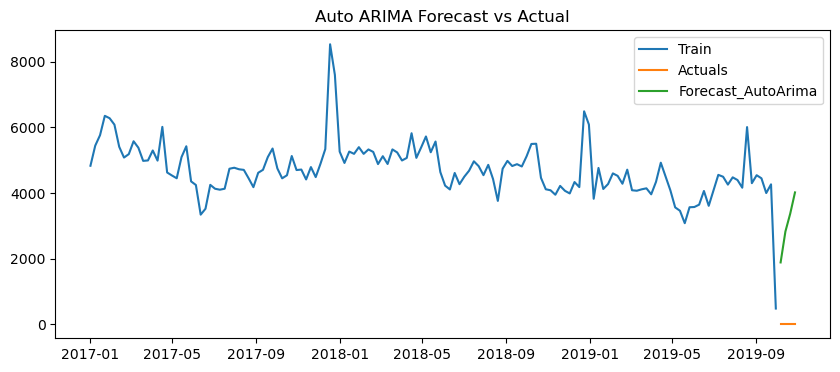

In [284]:
#Forecast the same number of steps as test set
n_periods_arima = len(y_test) # 4 weeks
forecast_arima = model_arima.predict(n_periods=n_periods_arima)

# Plot Forecast vs Actuals
plt.figure(figsize=(10, 4))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index, y_test, label="Actuals")
plt.plot(y_test.index, forecast_arima, label="Forecast_AutoArima")
plt.title("Auto ARIMA Forecast vs Actual")
plt.legend()
plt.show()

#### Performance

In [286]:
actual_values = y_test

mae_arima = mean_absolute_error(actual_values, forecast_arima)
mape_arima = mean_absolute_percentage_error(actual_values, forecast_arima)


print(f"MAE_AutoARIMA: {mae_arima:.2f}") # On average the model is off by...
print(f"MAPE_AutoARIMA: {mape_arima:.2f}") #On percentage how far the model is
print(f"AIC_AutoARIMA: {model_arima.aic():.2f}") # A measure of model to compare models
print(f"BIC_AutoARIMA: {model_arima.bic():.2f}") # same as above

MAE_AutoARIMA: 3026.37
MAPE_AutoARIMA: 13629542898678124544.00
AIC_AutoARIMA: 2269.92
BIC_AutoARIMA: 2287.70


In [287]:
#Check if forecasts are different
#print(np.allclose(forecast_arimax, forecast_arima))

# Output = True, it means that the model is ignoring the exogenousw

#### Fit Auto-ARIMAX Model - Training Data

In [289]:
# Creation of exogenous columns

exog_cols = ["stock",
             "promo_bin_1", 
             "promo_bin_2",
             "price",
             "n_unique_products",
             "store_size",
             "week_number",
            "month",
             "year"
            ]

# Define target and exogenous variables
y_train = train_data["sales"]
y_test = test_data["sales"]


X_train = train_data[exog_cols]
X_test = test_data[exog_cols]

# Ensure all exogenous variables are float or int (no UInt32, no objects)
X_train = X_train.astype("float64")
X_test = X_test.astype("float64")

model_arimax = auto_arima(
    y=y_train, # Train target variable
    exogenous = X_train, # exo variables to insert in the model 
    seasonal=True, # Seasonal Set true because data shows weekly seasonality
    m=52, # The period for seasonal differencing "52 weeks"
    stepwise=True, # Auto-Arima model selection to find the best ARIMA parameters
    trace=True, #print status on the fits
    error_action="ignore" # Ignores errors
)

# Summary
## There's no need to use fit() because Auto-Arima already does it
model_arimax.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=5.26 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=2285.475, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=2284.951, Time=1.12 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=2283.474, Time=1.15 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=2283.745, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[52] intercept   : AIC=2282.792, Time=0.04 sec
 ARIMA(0,1,1)(1,0,0)[52] intercept   : AIC=2283.613, Time=1.05 sec
 ARIMA(0,1,1)(1,0,1)[52] intercept   : AIC=inf, Time=2.31 sec
 ARIMA(1,1,1)(0,0,0)[52] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[52] intercept   : AIC=2274.150, Time=0.08 sec
 ARIMA(0,1,2)(1,0,0)[52] intercept   : AIC=2275.212, Time=2.52 sec
 ARIMA(0,1,2)(0,0,1)[52] intercept   : AIC=2275.088, Time=3.09 sec
 ARIMA(0,1,2)(1,0,1)[52] intercept   : AIC=inf, Time=3.35 sec
 ARIMA(1,1,2)(0,0,0)[52] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,3)(0,0,0)[52] intercept   : AIC=2

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  144
Model:               SARIMAX(1, 1, 4)   Log Likelihood               -1128.961
Date:                Sun, 13 Jul 2025   AIC                           2269.922
Time:                        17:03:09   BIC                           2287.699
Sample:                    01-02-2017   HQIC                          2277.146
                         - 09-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6368      0.345     -1.844      0.065      -1.314       0.040
ma.L1          0.3301      0.330      0.999      0.318      -0.317       0.978
ma.L2         -0.4971      0.146     -3.401      0.001      -0.784      -0.211
ma.L3         -0.3091      0.189     -1.635      0.102      -0.680       0.062
ma.L4         -0.2832      0.095     -2.986      0.003      -0.469      -0.097
sigma2      4.133e+05    2.4e+04     17.231      0.000    3.66e+05     4.6e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               821.11
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.87   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Forecasting & Plot Forecast vs Actual

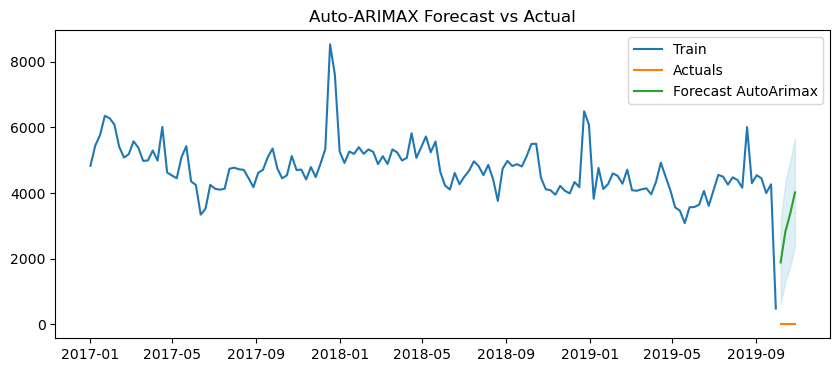

In [291]:
#Forecast the same number of steps as test set
n_periods_arimax = len(y_test) # 4 weeks
forecast_arimax, conf_int_arimax = model_arimax.predict(
    n_periods=n_periods_arimax,
    exogenous=X_test,
    return_conf_int=True
)

# Plot Forecast vs Actuals
plt.figure(figsize=(10, 4))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index, y_test, label="Actuals")
plt.plot(y_test.index, forecast_arimax, label="Forecast AutoArimax")  # <-- esta linha dava erro antes
plt.fill_between(y_test.index, conf_int_arimax[:, 0], conf_int_arimax[:, 1], color="lightblue", alpha=0.4)
plt.title("Auto-ARIMAX Forecast vs Actual")
plt.legend()
plt.show()

#### Performance

In [293]:
actual_values = y_test

mae_arimax = mean_absolute_error(actual_values, forecast_arimax)
mape_arimax = mean_absolute_percentage_error(actual_values, forecast_arimax)


print(f"MAE_AutoARIMAX: {mae_arimax:.2f}") # On average the model is off by...
print(f"MAPE_AutoARIMAX: {mape_arimax:.2f}") #On percentage how far the model is
print(f"AIC_AutoARIMAX: {model_arimax.aic():.2f}") # A measure of model to compare models
print(f"BIC_AutoARIMAX: {model_arimax.bic():.2f}") # same as above

MAE_AutoARIMAX: 3026.37
MAPE_AutoARIMAX: 13629542898678124544.00
AIC_AutoARIMAX: 2269.92
BIC_AutoARIMAX: 2287.70


#### Feature Importance

In [295]:
# Checking correlations:
df_h00_model.corr()["sales"].sort_values(ascending=False)
## Correlation values shows that stock is positively correlated with sales- (stockouts hurt performance
## Price, store_size and time variables are negatively correlated
## Promotions have low to moderate negative correlations - maybe because of they are binary and sporadic

sales                1.000000
stock                0.824883
promo_bin_1         -0.159549
month               -0.180511
week_number         -0.215074
promo_bin_2         -0.388389
n_unique_products   -0.424234
year                -0.437475
price               -0.460115
store_size          -0.486761
Name: sales, dtype: float64

Let's test our ARIMAX model with other features!!!

### Auto-ARIMA["stock"]

In [298]:
model_arimax_stock = auto_arima(
    y_train,
    exogenous=X_train["stock"],
    seasonal=True,
    stepwise=True,
    trace=True
)
forecast_arimax_stock = model_arimax_stock.predict(
    n_periods=len(y_test),
    exogenous=X_test["stock"]
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2285.475, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2284.627, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2282.792, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2283.745, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2274.150, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2273.467, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2276.316, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2270.029, Time=0.20 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2272.039, Time=0.19 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=2272.305, Time=0.28 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=2271.618, T

In [299]:
mae_arimax_stock = mean_absolute_error(y_test, forecast_arimax_stock)
mape_arimax_stock = mean_absolute_percentage_error(y_test, forecast_arimax_stock)


print(f"MAE_AutoARIMAX_stock: {mae_arimax_stock:.2f}") # On average the model is off by...
print(f"MAPE_AutoARIMAX_stock: {mape_arimax_stock:.2f}") #On percentage how far the model is
print(f"AIC_AutoARIMAX_stock: {model_arimax_stock.aic():.2f}") # A measure of model to compare models
print(f"BIC_AutoARIMAX_stock: {model_arimax_stock.bic():.2f}") # same as above

MAE_AutoARIMAX_stock: 3026.37
MAPE_AutoARIMAX_stock: 13629542898678124544.00
AIC_AutoARIMAX_stock: 2269.92
BIC_AutoARIMAX_stock: 2287.70


### Auto-ARIMA["stock", "price"]

In [301]:
model_arimax_stock_price = auto_arima(
    y_train,
    exogenous=X_train[["stock", "price"]],
    seasonal=True,
    stepwise=True,
    trace=True
)
forecast_arimax_stock_price = model_arimax_stock_price.predict(
    n_periods=len(y_test),
    exogenous=X_test[["stock", "price"]]
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2285.475, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2284.627, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2282.792, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2283.745, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2274.150, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2273.467, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2276.316, Time=0.12 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2270.029, Time=0.22 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2272.039, Time=0.18 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=2272.305, Time=0.25 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=2271.618, T

In [302]:
mae_arimax_stock_price = mean_absolute_error(y_test, forecast_arimax_stock_price)
mape_arimax_stock_price = mean_absolute_percentage_error(y_test, forecast_arimax_stock_price)


print(f"MAE_AutoARIMAX_stock_price: {mae_arimax_stock_price:.2f}") # On average the model is off by...
print(f"MAPE_AutoARIMAX_stock_price: {mape_arimax_stock_price:.2f}") #On percentage how far the model is
print(f"AIC_AutoARIMAX_stock_price: {model_arimax_stock_price.aic():.2f}") # A measure of model to compare models
print(f"BIC_AutoARIMAX_stock_price: {model_arimax_stock_price.bic():.2f}") # same as above

MAE_AutoARIMAX_stock_price: 3026.37
MAPE_AutoARIMAX_stock_price: 13629542898678124544.00
AIC_AutoARIMAX_stock_price: 2269.92
BIC_AutoARIMAX_stock_price: 2287.70


### Auto-ARIMA-TopFeatures

In [304]:
model_arimax_topfeatures = auto_arima(
    y_train,
    exogenous=X_train[["stock", "price", "store_size", "year", "n_unique_products"]],
    seasonal=True,
    stepwise=True,
    trace=True
)
forecast_arimax_topfeatures = model_arimax_topfeatures.predict(
    n_periods=len(y_test),
    exogenous=X_test[["stock", "price", "store_size", "year", "n_unique_products"]]
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2285.475, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2284.627, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2282.792, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2283.745, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2274.150, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2273.467, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2276.316, Time=0.11 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=2270.029, Time=0.19 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2272.039, Time=0.18 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=2272.305, Time=0.24 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=2271.618, T

In [305]:
mae_arimax_topfeatures = mean_absolute_error(y_test, forecast_arimax_topfeatures)
mape_arimax_topfeatures = mean_absolute_percentage_error(y_test, forecast_arimax_topfeatures)


print(f"MAE_AutoARIMAX_topfeatures: {mae_arimax_topfeatures:.2f}") # On average the model is off by...
print(f"MAPE_AutoARIMAX_topfeatures: {mape_arimax_topfeatures:.2f}") #On percentage how far the model is
print(f"AIC_AutoARIMAX_topfeatures: {model_arimax_topfeatures.aic():.2f}") # A measure of model to compare models
print(f"BIC_AutoARIMAX_topfeatures: {model_arimax_topfeatures.bic():.2f}") # same as above

MAE_AutoARIMAX_topfeatures: 3026.37
MAPE_AutoARIMAX_topfeatures: 13629542898678124544.00
AIC_AutoARIMAX_topfeatures: 2269.92
BIC_AutoARIMAX_topfeatures: 2287.70


### Linear Regression

In [307]:
lr_stock_price = LinearRegression()
lr_stock_price.fit(X_train[["stock", "price"]], y_train)
y_pred_lr_stock_price = lr_stock_price.predict(X_test)
print("Linear Regression STOCK, PRICE variables\n")
print(f"MAE LinearRegression: {mean_absolute_error(y_test, y_pred_lr_stock_price):.2f}")
print(f"MAPE LinearRegression: {mean_absolute_percentage_error(y_test, y_pred_lr_stock_price):.2f}")
print(f"""LR with exogenous variables["stock", "price"] showed a low MAE: {mean_absolute_error(y_test, y_pred_lr_stock_price):.2f} we can conclude that suggests that some of your exogenous variables (like stock, price, etc.) are indeed predictive of sales.""")

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- month
- n_unique_products
- promo_bin_1
- promo_bin_2
- store_size
- ...


In [ ]:
# Visualizations of Exogenous Feature Importance
importance = pd.Series(lr_stock_price.coef_, index=["stock", "price"])
importance.plot(kind="barh")
plt.ylabel("Coefficient Value")
plt.title("Linear Regression Coefficients")
plt.show()

In [ ]:
print("Interpretation of the Linear Regression Coeficients\n")
print("Price - One unit increase in price the sales are predicted to decrease by ~140 units, while stock remains constant")
print("Stock - One unit increase in stock the sales are predicted to increase by ~100 units, while price remains constant")

### ARIMA Results

In [ ]:
# Compile results
results = [
    {
        "Model": "ARIMA",
        "Exogs Used": "None",
        "MAE": mae_arima,
        "MAPE": mape_arima,
        "AIC": model_arima.aic(),
        "BIC": model_arima.bic()
    },
    {
        "Model": "ARIMAX",
        "Exogs Used": "Stock",
        "MAE": mae_arimax_stock,
        "MAPE": mape_arimax_stock,
        "AIC": model_arimax_stock.aic(),
        "BIC": model_arimax_stock.bic()
    },
    {
        "Model": "ARIMAX",
        "Exogs Used": "Stock + Price",
        "MAE": mae_arimax_stock_price,
        "MAPE": mape_arimax_stock_price,
        "AIC": model_arimax_stock_price.aic(),
        "BIC": model_arimax_stock_price.bic()
    },
    {
        "Model": "ARIMAX",
        "Exogs Used": "Top 5 Features",
        "MAE": mae_arimax_topfeatures,
        "MAPE": mape_arimax_topfeatures,
        "AIC": model_arimax_topfeatures.aic(),
        "BIC": model_arimax_topfeatures.bic()
    },
    {
        "Model": "ARIMAX",
        "Exogs Used": "All Features",
        "MAE": mae_arimax,
        "MAPE": mape_arimax,
        "AIC": model_arimax.aic(),
        "BIC": model_arimax.bic()
    },
    {
        "Model": "LinearReg",
        "Exogs Used": "Stock + Price",
        "MAE": mean_absolute_error(y_test, y_pred_lr_stock_price),
        "MAPE": mean_absolute_percentage_error(y_test, y_pred_lr_stock_price),
        "AIC": "—",
        "BIC": "—"
    }
]

# Create DataFrame
results_df = pd.DataFrame(results)
#print(results_df.to_markdown(index=False))
results_df

#### Time-Series Cross-Validation

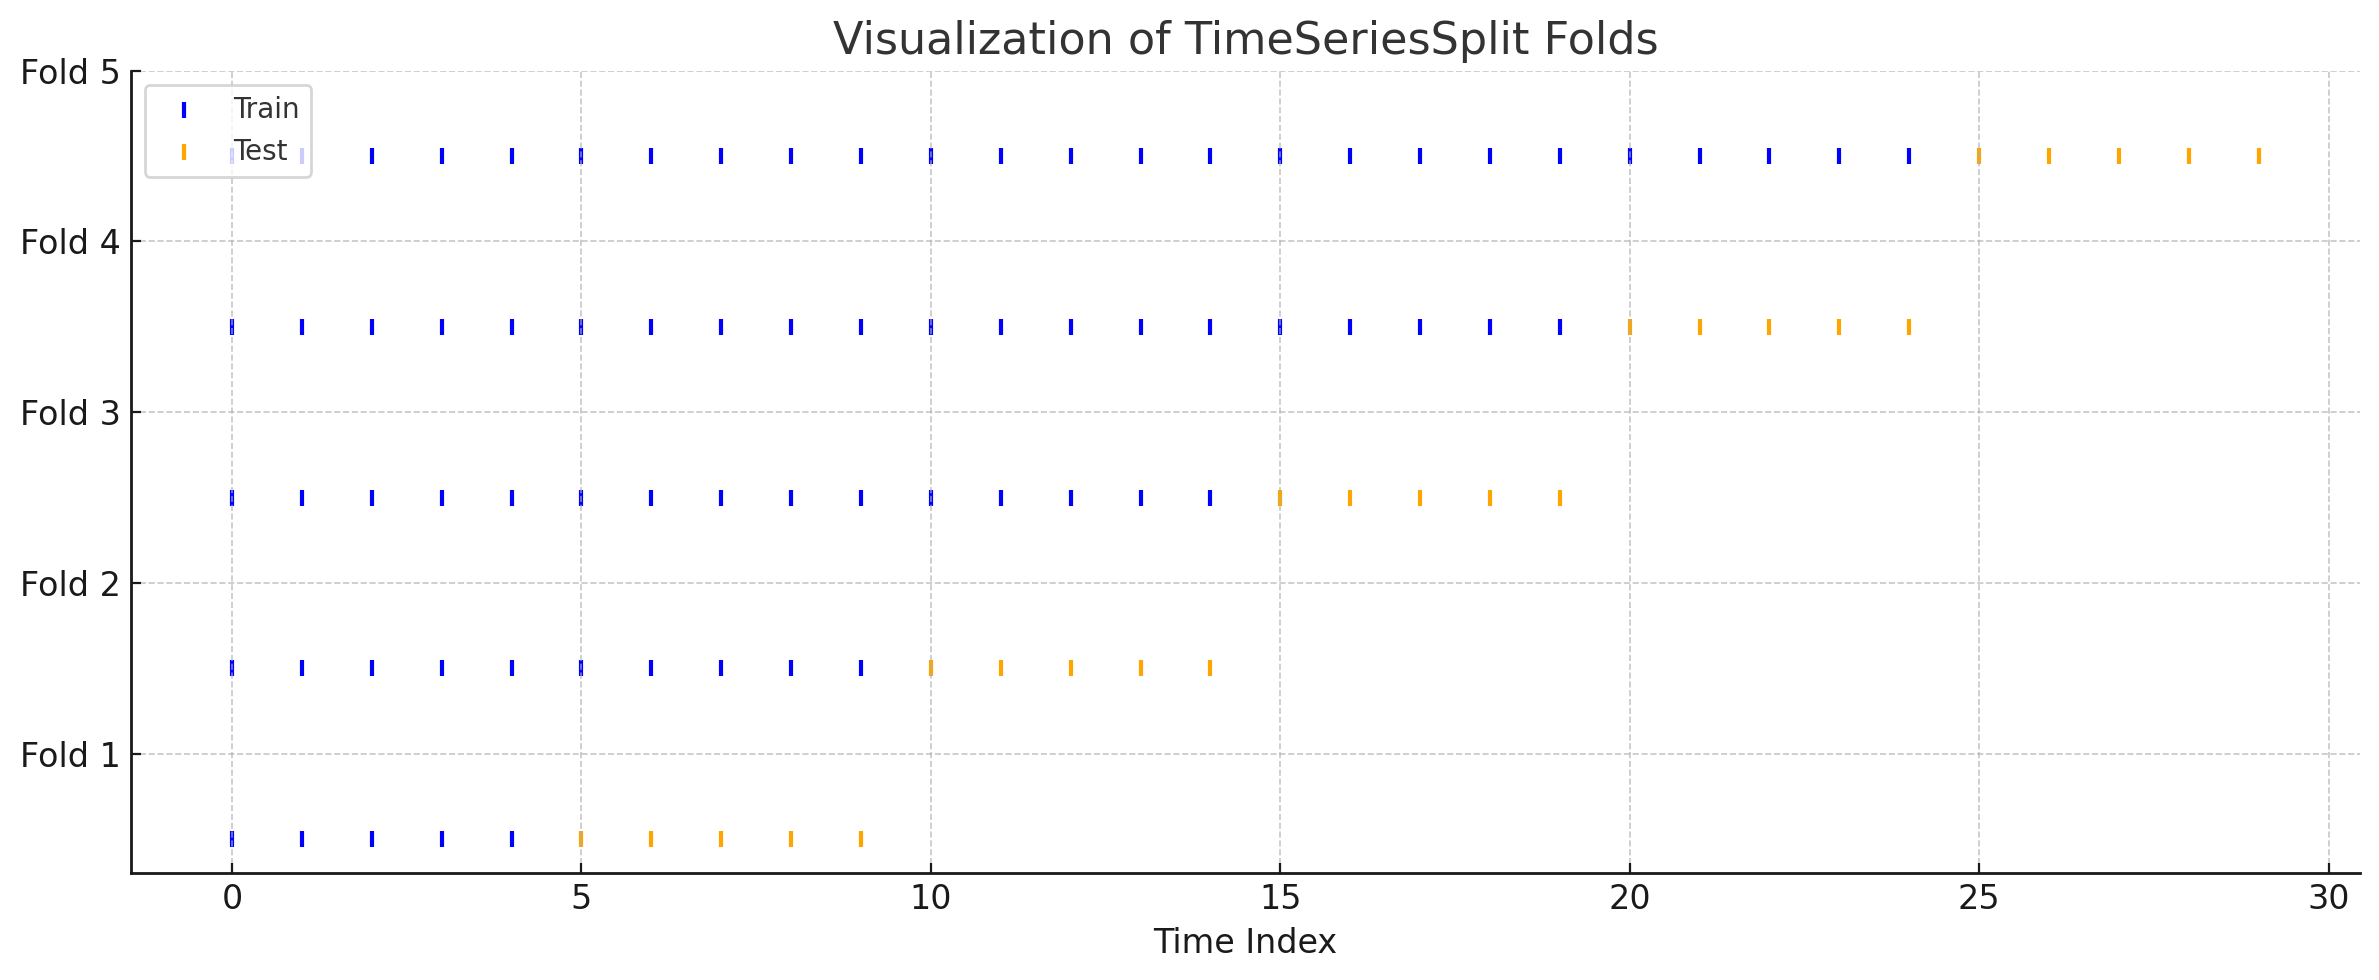

Each row represents one fold (Fold 1 to Fold 5)

Blue bars: training data used in that fold

Orange bars: test data used in that fold

The training window grows with each fold (this is an expanding window strategy)

Even though the X-axis is numeric (0–29), each point corresponds to a specific week in the week column.

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
for train_idx, test_idx in tscv.split(df_isna_filtered_week):
    train_tscv = df_isna_filtered_week.iloc[train_idx]
    test_tscv = df_isna_filtered_week.iloc[test_idx]

train_tscv.shape#.head()

In [ ]:
#Rest of the model with fit

## Drafts

#### filtered_df (Stores by product)

In [ ]:
stores = ['S0085', 'S0095', 'S0080', 'S0026']

filtered_df = df_isna[df_isna["store_id"].isin(stores) & (df_isna["product_id"] == "P0015")]
filtered_df

In [ ]:
price_comparison = filtered_df[["week", "store_id", "product_id", "price"]].drop_duplicates().set_index("week")
price_comparison.groupby("store_id")["price"].mean().plot(kind="bar");
plt.title("Price of P0015 Across Stores")
plt.ylabel("Price")
plt.show()

In [ ]:
sns.lineplot(data=filtered_df, x="week", y="price", hue="store_id", marker="o", ci=None)
plt.title(f'Weekly Price Trends')
plt.xlabel('Week')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
filtered_df[["week", "store_id", "product_id", "price"]].drop_duplicates().set_index("week")

In [ ]:
import plotly.express as px

fig = px.line(
    filtered_df,
    x='week',
    y='price',
    color='store_id',
    title=f'Price Trends',
    labels={'price': 'Price ($)', 'date': 'Date'},
    hover_data=['store_id', 'product_id']
)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [ ]:
## just continue with the full data ARIMA model

## ARIMA 

### Train-Test Split

In [ ]:
train_data = df_h00_model.iloc[:-4]
test_data = df_h00_model.iloc[-4:]

print(len(train_data))
print(len(test_data))
print(train_data.index.max()) # last week of training data
print(test_data.index.min()) # first week of test data

### ARIMA - XREG / ARIMAX

#### Fit Arima Model

In [ ]:
# Define target and exogenous variables
y_train = train_data["sales"]
y_test = test_data["sales"]

model_arima = auto_arima(
    y_train, # Train target variable
    seasonal=True, # Seasonal Set true because data shows weekly seasonality
    m=52, # The period for seasonal differencing "52 weeks"
    stepwise=False, # <- Disable shortcut search
    trace=True, #print status on the fits
    error_action="ignore", # Ignores errors
    max_p=3, max_q=3, max_P=2, max_Q=2,  # Expand search grid
    d=None, D=None  # Let it infer order of differencing
)

# Summary
## There's no need to use fit() because Auto-Arima already does it
model_arima.summary()

#### Fit ARIMAX Model - Training Data

In [ ]:
# Creation of exogenous columns

exog_cols = ["stock",
             "promo_bin_1", 
             "promo_bin_2",
             "price",
             "n_unique_products",
             "store_size",
             "week_number",
            "month",
             "year"
            ]

# Define target and exogenous variables
y_train = train_data["sales"]
y_test = test_data["sales"]


X_train = train_data[exog_cols]
X_test = test_data[exog_cols]

# Ensure all exogenous variables are float or int (no UInt32, no objects)
X_train = X_train.astype("float64")
X_test = X_test.astype("float64")

model_arimax = auto_arima(
    y=y_train, # Train target variable
    exogenous = X_train, # exo variables to insert in the model 
    seasonal=True, # Seasonal Set true because data shows weekly seasonality
    m=52, # The period for seasonal differencing "52 weeks"
    stepwise=False, # <- Disable shortcut search
    trace=True, #print status on the fits
    error_action="ignore", # Ignores errors
    max_p=3, max_q=3, max_P=2, max_Q=2,  # Expand search grid
    d=None, D=None  # Let it infer order of differencing
)

# Summary
model_arimax.summary()

#### Forecasting & Plot Forecast vs Actual

In [ ]:
#Forecast the same number of steps as test set
n_periods_arimax = len(y_test) # 4 weeks
forecast_arimax, conf_int_arimax = model_arimax.predict(
    n_periods=n_periods_arimax,
    exogenous=X_test,
    return_conf_int=True
)

# Plot Forecast vs Actuals
plt.figure(figsize=(10, 4))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index, y_test, label="Actuals")
plt.plot(y_test.index, forecast_arimax, label="Forecast AutoArimax")  # <-- esta linha dava erro antes
plt.fill_between(y_test.index, conf_int_arimax[:, 0], conf_int_arimax[:, 1], color="lightblue", alpha=0.4)
plt.title("Auto-ARIMAX Forecast vs Actual")
plt.legend()
plt.show()

#### Performance

In [ ]:
actual_values = y_test

mae_arimax = mean_absolute_error(actual_values, forecast_arimax)
mape_arimax = mean_absolute_percentage_error(actual_values, forecast_arimax)


print(f"MAE_AutoARIMAX: {mae_arimax:.2f}") # On average the model is off by...
print(f"MAPE_AutoARIMAX: {mape_arimax:.2f}") #On percentage how far the model is
print(f"AIC_AutoARIMAX: {model_arimax.aic():.2f}") # A measure of model to compare models
print(f"BIC_AutoARIMAX: {model_arimax.bic():.2f}") # same as above

### ARIMA

| Strength                                      | Why it matters for inventory                                                                                   |
| --------------------------------------------- | -------------------------------------------------------------------------------------------------------------- |
| 📉 **Short-term accuracy**                    | ARIMA excels at capturing local patterns like last few weeks’ sales — critical for weekly inventory decisions. |
| 🧮 **Interpretable**                          | Easy to understand and control: “Use last 2 weeks, difference once, correct with recent error.”                |
| 🔁 **Well-tested for univariate time series** | Forecasting **one variable** (sales per product/store) is ARIMA’s wheelhouse.                                  |


#### Forecasting & Plot Forecast vs Actual

In [ ]:
#Forecast the same number of steps as test set
n_periods_arima = len(y_test) # 4 weeks
forecast_arima = model_arima.predict(n_periods=n_periods_arima)

# Plot Forecast vs Actuals
plt.figure(figsize=(10, 4))
plt.plot(y_train.index, y_train, label="Train")
plt.plot(y_test.index, y_test, label="Actuals")
plt.plot(y_test.index, forecast_arima, label="Forecast_AutoArima")
plt.title("Auto ARIMA Forecast vs Actual")
plt.legend()
plt.show()

#### Performance

In [ ]:
actual_values = y_test

mae_arima = mean_absolute_error(actual_values, forecast_arima)
mape_arima = mean_absolute_percentage_error(actual_values, forecast_arima)


print(f"MAE_AutoARIMA: {mae_arima:.2f}") # On average the model is off by...
print(f"MAPE_AutoARIMA: {mape_arima:.2f}") #On percentage how far the model is
print(f"AIC_AutoARIMA: {model_arima.aic():.2f}") # A measure of model to compare models
print(f"BIC_AutoARIMA: {model_arima.bic():.2f}") # same as above

In [ ]:
#Check if forecasts are different
print(np.allclose(forecast_arimax, forecast_arima))

# Output = True, it means that the model is ignoring the exogenous

In [ ]:
# Checking correlations:
df_h00_model.corr()["sales"].sort_values(ascending=False)
## Correlation values shows that stock is positively correlated with sales- (stockouts hurt performance
## Price, store_size and time variables are negatively correlated
## Promotions have low to moderate negative correlations - maybe because of they are binary and sporadic

Let's test our ARIMAX model with other features!!!

### Auto-ARIMA["stock"]

In [ ]:
model_arimax_stock = auto_arima(
    y_train,
    exogenous=X_train["stock"],
    seasonal=False,
    stepwise=True,
    trace=True
)
forecast_arimax_stock = model_arimax_stock.predict(
    n_periods=len(y_test),
    exogenous=X_test["stock"]
)

In [ ]:
mae_arimax_stock = mean_absolute_error(y_test, forecast_arimax_stock)
mape_arimax_stock = mean_absolute_percentage_error(y_test, forecast_arimax_stock)


print(f"MAE_AutoARIMAX_stock: {mae_arimax_stock:.2f}") # On average the model is off by...
print(f"MAPE_AutoARIMAX_stock: {mape_arimax_stock:.2f}") #On percentage how far the model is
print(f"AIC_AutoARIMAX_stock: {model_arimax_stock.aic():.2f}") # A measure of model to compare models
print(f"BIC_AutoARIMAX_stock: {model_arimax_stock.bic():.2f}") # same as above

### Auto-ARIMA["stock", "price"]

In [ ]:
model_arimax_stock_price = auto_arima(
    y_train,
    exogenous=X_train[["stock", "price"]],
    seasonal=False,
    stepwise=True,
    trace=True
)
forecast_arimax_stock_price = model_arimax_stock_price.predict(
    n_periods=len(y_test),
    exogenous=X_test[["stock", "price"]]
)

In [ ]:
mae_arimax_stock_price = mean_absolute_error(y_test, forecast_arimax_stock_price)
mape_arimax_stock_price = mean_absolute_percentage_error(y_test, forecast_arimax_stock_price)


print(f"MAE_AutoARIMAX_stock_price: {mae_arimax_stock_price:.2f}") # On average the model is off by...
print(f"MAPE_AutoARIMAX_stock_price: {mape_arimax_stock_price:.2f}") #On percentage how far the model is
print(f"AIC_AutoARIMAX_stock_price: {model_arimax_stock_price.aic():.2f}") # A measure of model to compare models
print(f"BIC_AutoARIMAX_stock_price: {model_arimax_stock_price.bic():.2f}") # same as above

### Auto-ARIMA-TopFeatures

In [ ]:
model_arimax_topfeatures = auto_arima(
    y_train,
    exogenous=X_train[["stock", "price", "store_size", "year", "n_unique_products"]],
    seasonal=False,
    stepwise=True,
    trace=True
)
forecast_arimax_topfeatures = model_arimax_topfeatures.predict(
    n_periods=len(y_test),
    exogenous=X_test[["stock", "price", "store_size", "year", "n_unique_products"]]
)

In [ ]:
mae_arimax_topfeatures = mean_absolute_error(y_test, forecast_arimax_topfeatures)
mape_arimax_topfeatures = mean_absolute_percentage_error(y_test, forecast_arimax_topfeatures)


print(f"MAE_AutoARIMAX_topfeatures: {mae_arimax_topfeatures:.2f}") # On average the model is off by...
print(f"MAPE_AutoARIMAX_topfeatures: {mape_arimax_topfeatures:.2f}") #On percentage how far the model is
print(f"AIC_AutoARIMAX_topfeatures: {model_arimax_topfeatures.aic():.2f}") # A measure of model to compare models
print(f"BIC_AutoARIMAX_topfeatures: {model_arimax_topfeatures.bic():.2f}") # same as above

### Linear Regression

In [ ]:
lr_stock_price = LinearRegression()
lr_stock_price.fit(X_train[["stock", "price"]], y_train)
y_pred_lr_stock_price = lr_stock_price.predict(X_test)
print("Linear Regression STOCK, PRICE variables\n")
print(f"MAE LinearRegression: {mean_absolute_error(y_test, y_pred_lr_stock_price):.2f}")
print(f"MAPE LinearRegression: {mean_absolute_percentage_error(y_test, y_pred_lr_stock_price):.2f}")
print(f"""LR with exogenous variables["stock", "price"] showed a low MAE: {mean_absolute_error(y_test, y_pred_lr_stock_price):.2f} we can conclude that suggests that some of your exogenous variables (like stock, price, etc.) are indeed predictive of sales.""")

In [ ]:
# Visualizations of Exogenous Feature Importance
importance = pd.Series(lr_stock_price.coef_, index=["stock", "price"])
importance.plot(kind="barh")
plt.ylabel("Coefficient Value")
plt.title("Linear Regression Coefficients")
plt.show()

In [ ]:
print("Interpretation of the Linear Regression Coeficients\n")
print("Price - One unit increase in price the sales are predicted to decrease by ~140 units, while stock remains constant")
print("Stock - One unit increase in stock the sales are predicted to increase by ~100 units, while price remains constant")

In [ ]:
# Compile results
results = [
    {
        "Model": "ARIMA",
        "Exogs Used": "None",
        "MAE": mae_arima,
        "MAPE": mape_arima,
        "AIC": model_arima.aic(),
        "BIC": model_arima.bic()
    },
    {
        "Model": "ARIMAX",
        "Exogs Used": "Stock",
        "MAE": mae_arimax_stock,
        "MAPE": mape_arimax_stock,
        "AIC": model_arimax_stock.aic(),
        "BIC": model_arimax_stock.bic()
    },
    {
        "Model": "ARIMAX",
        "Exogs Used": "Stock + Price",
        "MAE": mae_arimax_stock_price,
        "MAPE": mape_arimax_stock_price,
        "AIC": model_arimax_stock_price.aic(),
        "BIC": model_arimax_stock_price.bic()
    },
    {
        "Model": "ARIMAX",
        "Exogs Used": "Top 5 Features",
        "MAE": mae_arimax_topfeatures,
        "MAPE": mape_arimax_topfeatures,
        "AIC": model_arimax_topfeatures.aic(),
        "BIC": model_arimax_topfeatures.bic()
    },
    {
        "Model": "ARIMAX",
        "Exogs Used": "All Features",
        "MAE": mae_arimax,
        "MAPE": mape_arimax,
        "AIC": model_arimax.aic(),
        "BIC": model_arimax.bic()
    },
    {
        "Model": "LinearReg",
        "Exogs Used": "Stock + Price",
        "MAE": mean_absolute_error(y_test, y_pred_lr_stock_price),
        "MAPE": mean_absolute_percentage_error(y_test, y_pred_lr_stock_price),
        "AIC": "—",
        "BIC": "—"
    }
]

# Create DataFrame
results_df = pd.DataFrame(results)
#print(results_df.to_markdown(index=False))
results_df